# mod2cen - run a set of c6 instances to test the effects of sensing distance on colony formation

Using the [c6](http://github.com/allencellmodeling/c6) model of cell colony formation, run a series of trials with the sensing distance tuned from low to high. 

In [1]:
import os
import uuid
from pathlib import Path
import multiprocessing as mp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import c6
from workflow_colony_formation import utils

In [2]:
config = utils.load_step_config('mod2cen', ['seg2cen', ])
    
# Find (and create if necessary) input and output dirs
root_dir = Path('../../..').resolve()
relative_local_staging = config.step_local_staging_dir
absolute_local_staging = root_dir / relative_local_staging
absolute_local_staging.mkdir(parents=True, exist_ok=True)

# Load the prior manifest
parent_manifest_fn = (absolute_local_staging / "../seg2cen/manifest.csv").resolve()
parent_manifest = pd.read_csv(parent_manifest_fn)
if not parent_manifest.filepath[0].startswith('local_staging'):
    parent_manifest.filepath = 'local_staging/seg2cen/' + parent_manifest.filepath
parent_manifest.head(3)

,filepath,original_image_series,region
0,local_staging/seg2cen/20170711_I01_0.csv,20170711_I01_0,0
1,local_staging/seg2cen/20170711_I01_1.csv,20170711_I01_1,1


We are going to create a set of initial conditions using only the output from the first region and model values derived from manual examination of runs. A more robust approach is certainly possible.

First we'll load the starting locations of the cells.

,area,centroid_x,centroid_y,cell_id,channel,original_czi,fluorophore,time,region,radius
0,34.65,1024.97,1.68,1,0,20170711_I01_001.czi,EGFP,0,0,3.32
1,156.53,1099.91,8.63,2,0,20170711_I01_001.czi,EGFP,0,0,7.06


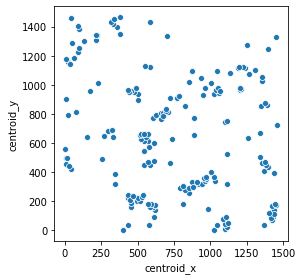

In [3]:
experimental_trace = pd.read_csv(root_dir/parent_manifest.filepath[0])
starting_locations = experimental_trace[experimental_trace.time==0]

fig, ax = plt.subplots()
sns.scatterplot('centroid_x', 'centroid_y', sizes='radius', data=starting_locations, ax=ax)
ax.set(aspect=1)
plt.tight_layout()

starting_locations.head(2)

And now we'll create many copies of the initial conditions, one per trial:

In [4]:
# Create dir 
initial_cond_dir = absolute_local_staging / 'initial_conditions'
initial_cond_dir.mkdir(parents=True, exist_ok=True)

# Set run parameters
if config.interactive:
    INFLUENCE_DECAYS = np.geomspace(.002,.2,3)
    COPIES = list(range(2))
    LENGTH = 5
else: 
    INFLUENCE_DECAYS = np.geomspace(.002, 2, 10) 
    COPIES = list(range(20))
    LENGTH = 120

# Repeatably random
np.random.seed(100)
# Make all the copies
initial_conditions_manifest = []
for influence_decay in INFLUENCE_DECAYS:
    for copy in COPIES:
        max_radius, min_radius = 9.2, 4.4  # loosely derived from areas
        for_all_cells = dict(
            age=0,
            growth_rate=0.1,
            growth_var=0.5,
            min_growth=0.01,
            min_radius=min_radius,
            max_radius=max_radius,
            rad_mult=1.6, 
            inhibition_n=4,
            inhibition_50=20,
            inhibition_steepness=3,
            mitosis_50=8.1,  # loosely derived from areas
            mitosis_steepness=0.01,
            sensing=40 * max_radius,
            influence_max=20,
            influence_decay=influence_decay,
            adhesion=0.1,  # 0.001,
            max_speed=4.0,  # 1.0,
            speed_dispersion=0.4,  # 0.03,
            direction_dispersion=0.1,
            repel_limit=1.0,
        )
        # Instantiate model
        space = c6.Space()
        cells = []
        for _, row in starting_locations.iterrows():
            cell = c6.Cell(
                space,
                (row.centroid_x, row.centroid_y),
                row.radius,
                dir=np.random.normal(size=2),  # gets normed below
                speed=np.abs(np.random.normal(0.5*for_all_cells['max_speed'], 
                                              0.1*for_all_cells['max_speed'])),
                **for_all_cells,
            )
            cells.append(cell)
        # Write out starting conditions
        base_fn = f"decay_{influence_decay:0.3f}_copy_{copy:02d}.initial.json"
        fn_out = initial_cond_dir / base_fn
        c6.utils.serialize.write_starting_conditions(
            fn_out, space, extra_top_level=dict(seed=copy), universal_keys=for_all_cells
        )
        # Save for posterity
        manifest_fn = relative_local_staging/'initial_conditions'/base_fn
        initial_conditions_manifest.append(dict(filepath=manifest_fn, 
                                                type='initial', 
                                                influence_decay=influence_decay, 
                                                copy=copy))

And a little example trial

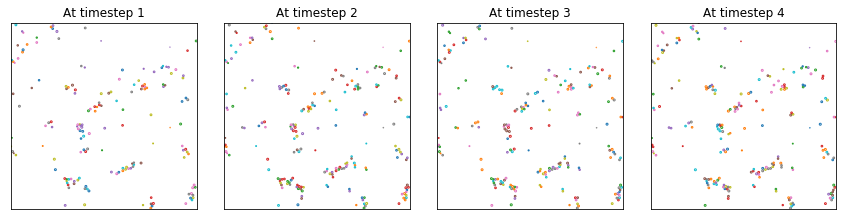

In [5]:
fig, axs = plt.subplots(1, 4, figsize=(12,3))
for ax in axs:
    c6.plot.plot_cells(space.cells, ax)
    space.step()
    max_vals = np.array([c.loc for c in space.cells]).max(0)
    ax.set(title = f"At timestep {space.timestep}",
           xlim = (0, max_vals[0]), 
           ylim = (0, max_vals[1]), 
           xticks = list(),
           yticks = list(),
           aspect=1,
          )
plt.tight_layout()

Now setup and run the trials

In [6]:
# Create dir 
out_dir = absolute_local_staging / 'runs'
out_dir.mkdir(parents=True, exist_ok=True)

def run(in_fn):
    """Perform a run given an input name"""
    in_fn = str(in_fn)
    out_fn = out_dir / in_fn.split("/")[-1][:-13]
    csvlog = c6.utils.serialize.CSVLog(out_fn)
    space = c6.utils.serialize.load_starting_conditions(in_fn)
    space._generate_distance_map()
    # set up animation
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    cell_locs = np.array([cell.loc for cell in space.cells])
    lim = (-100, 100 + np.round(cell_locs.max()))
    ax.set(xlim=lim, ylim=lim, aspect=1)

    def update(space):
        csvlog.log_space(space)

    animation = c6.plot.animate(fig, ax, space, LENGTH, update)
    animation.save(str(out_fn) + ".mp4", fps=10)
    for t in range(LENGTH):
        space.step()
    csvlog.close()
    return out_fn

In [7]:
with mp.Pool(mp.cpu_count()) as pool:
    log_fns = pool.map(run, initial_cond_dir.iterdir())

Let's take a look at one of those outputs. I'm going to plot a somewhat complex diagnostic and then take a moment to explain it. 

   t      id        x        y     dir_x     dir_y    speed  radius  age  \
0  1  BAf4bA  1025.26  3.89796  0.129766  0.991545  2.23688    3.32    1   

  parent  
0    NaN  


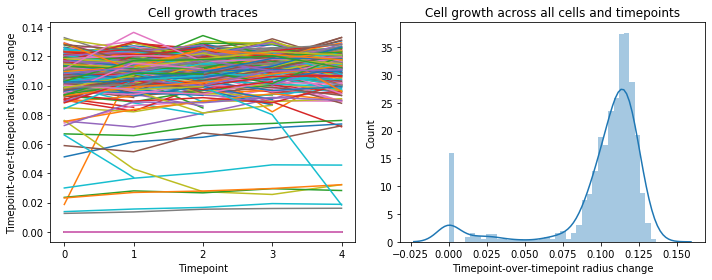

In [8]:
# Load a log
df = pd.read_csv(str(log_fns[0])+".c6log")
print(df.head(1))

# Set up the axes
fig, axs = plt.subplots(1,2,figsize=(10,4))

# Plot the cell growth rate traces
rds = []
for cell_id in df.id.unique():
    rad_delt = np.diff(df[(df.id==cell_id)].sort_values('t').radius.values)
    rds += list(rad_delt)
    axs[0].plot(range(len(rad_delt)), rad_delt)
axs[0].set(
    title="Cell growth traces", 
    ylabel="Timepoint-over-timepoint radius change", 
    xlabel="Timepoint",
    xticks=range(df.t.max()-1),
)

# Plot the cell growth rate distributions 
sns.distplot(rds, ax=axs[1])
axs[1].set(
    title="Cell growth across all cells and timepoints", 
    ylabel="Count",
    xlabel="Timepoint-over-timepoint radius change", 
)
plt.tight_layout()

What we are looking at on the left are per-cell traces of the amount of growth (change in radius) between each time point. So most cells are growing at a steady clip, their rate profiles are flat, but a few have variable growth rates as a result of either nearing the maximum supported cell size or falling under the influence of contact inhibition of growth. 

On the right we have the distribution of growth rates across all cells at all time points. Most cells are growing somewhere around 0.01µm per timestep with a few above and a few below that. 

These match my intuition for what the growth rates should show, so we'll call this a successful run and move on to generating the manifest of the resulting files. 

In [9]:
manifests = initial_conditions_manifest
for fn in log_fns:
    name = fn.name
    fn = relative_local_staging/'runs'/fn.name
    csv = str(fn)+".c6log"
    mp4 = str(fn)+".mp4"
    decay = float(fn.name.split('_')[1])
    copy = int(fn.name.split('_')[3])
    manifests.append(dict(filepath=csv, type='log', influence_decay=decay, copy=copy))
    manifests.append(dict(filepath=mp4, type='render', influence_decay=decay, copy=copy))

config.manifest = pd.DataFrame(manifests)
config.metadata_columns = ['type', 'influence_decay', 'copy']
utils.dump_step_config(config)
config.manifest.head(2)

,filepath,type,influence_decay,copy
0,local_staging/mod2cen/initial_conditions/decay...,initial,0.002,0
1,local_staging/mod2cen/initial_conditions/decay...,initial,0.002,1
